In [1]:
import OpenCity
import PreCompOsmNet

In [2]:
import osmnx

In [3]:
fips=25
year=2017
geom_type='block'
centre= {'lat': 42.352927, 'lon': -71.059435}
centre_x_y=[centre['lon'], centre['lat']]

model_area_radius=5000
sim_area_radius=1000

state=OpenCity.US_State(state_fips=fips, year=year, 
#                         geom_type=geom_type
                       )
state.get_geometry()

Getting geometry (block_group) for state: Massachusetts


/Volumes/GoogleDrive/My Drive/OpenCity/OpenCity.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=self.geom['geometry'].centroid


In [4]:
state.subset_geom_by_distance(centre_x_y, model_area_radius, 'model_area')
state.subset_geom_by_distance(centre_x_y, sim_area_radius, 'vis_area')

	 Subsetting zones by distance
	 Subsetting zones by distance


In [5]:
all_zones=state.return_geometry()
sim_zones=state.return_geometry('vis_area')
model_zones=state.return_geometry('model_area')

In [6]:
state.get_lodes_data()
simpop_df=state.lodes_to_pop_table(subset_name='model_area')

Getting WAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting WAC data
Getting RAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting RAC data
Getting OD data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting OD data
Using 27680 of 1498059 rows in OD data
0 of 27680
10000 of 27680
20000 of 27680


In [7]:
osmnx.utils.config(bidirectional_network_types=['walk', 'drive', 'cycle'])
print('Getting walk network')
G_walk = osmnx.graph.graph_from_point([centre['lat'], centre['lon']], 
                                      dist=sim_area_radius, network_type='walk')
for edge in list(G_walk.edges):
    G_walk.edges[edge]['speed_kph']=4.8
G_walk=PreCompOsmNet.simplify_network(G_walk)
G_walk=osmnx.add_edge_travel_times(G_walk)
fw_pred_walk=PreCompOsmNet.pre_compute_paths(G_walk)
pre_comp_walk=PreCompOsmNet.PreCompOSMNet(G_walk, fw_pred_walk)

print('Getting drive network')
G_drive = osmnx.graph.graph_from_point([centre['lat'], centre['lon']], 
                                       dist=sim_area_radius, network_type='drive')
G_drive = osmnx.add_edge_speeds(G_drive)
G_drive=PreCompOsmNet.simplify_network(G_drive)
# compute speeds
G_drive=osmnx.add_edge_travel_times(G_drive)
fw_pred_drive=PreCompOsmNet.pre_compute_paths(G_drive)
pre_comp_drive=PreCompOsmNet.PreCompOSMNet(G_drive, fw_pred_drive)

Getting walk network
	 Simplified from 14744 to 5252 edges and 4537 to 835 nodes
	 Pre-computing paths
Getting drive network
	 Simplified from 1502 to 1330 edges and 491 to 409 nodes
	 Pre-computing paths


In [8]:
networks={'drive': pre_comp_drive, 'walk': pre_comp_walk}

drive_dict={
    'target_network_id': 'drive',
    'travel_time_metric': 'travel_time'}
walk_dict={
    'target_network_id': 'walk',
    'travel_time_metric': 'travel_time'}

modes={'drive': OpenCity.Mode(drive_dict), 
       'walk': OpenCity.Mode(walk_dict)}

mob_sys=OpenCity.MobilitySystem(modes=modes, networks= networks)

In [9]:
sim=OpenCity.Simulation(simpop_df, mob_sys, model_zones)
simpop_df=sim.get_simpop_subset(simpop_df, sample_N=1000, sim_geoids=list(sim_zones.index))
simpop_df=sim.create_activity_schedules(simpop_df)
all_trips_df=sim.create_trip_table(simpop_df)
route_table=sim.get_routes_table(all_trips_df)
route_gdf=sim.route_table_to_geo(route_table)

Finding closest nodes to every zone centroid
Scheduling activities
Chhosing locations for each activity
Choosing modes


<AxesSubplot:>

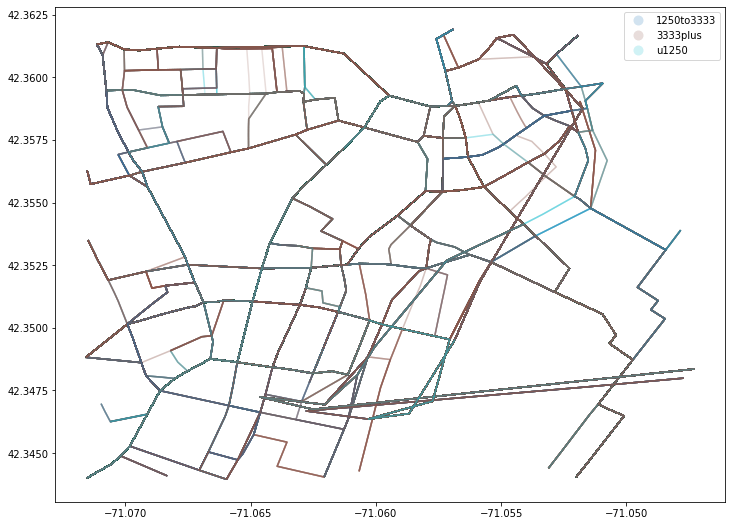

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(12,12))
route_gdf.plot(column='earnings', legend=True, alpha=0.2, ax=ax)